In [34]:
import os
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import RSLPStemmer  # Portuguese stemmer
import nltk
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pickle
import unicodedata
from wordcloud import WordCloud

In [35]:
# Download required NLTK resources

In [36]:
# Set NLTK data path to custom directory
nltk.data.path.append('../static/model/nltk_data')  

# Download required resources to the correct location
nltk.download('rslp', download_dir='../static/model/nltk_data')
nltk.download('stopwords', download_dir='../static/model/nltk_data')

[nltk_data] Downloading package rslp to ../static/model/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     ../static/model/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [37]:
train_df  = pd.read_csv('../artifacts/Train.csv')
test_df = pd.read_csv('../artifacts/Test.csv')

In [38]:
print("Train data shape:", train_df.shape)
print("\nTrain data sample:")
train_df.head(5)

Train data shape: (50000, 5)

Train data sample:


,id,tweet,tweet_date,label,query_used
0,1.049160e+18,@Vini_Arisato eu espero que não,Mon Oct 08 04:44:32 +0000 2018,0,:(
1,1.049100e+18,me diz aí o que vai ser do serviço social com ...,Mon Oct 08 01:10:03 +0000 2018,1,:)
2,1.050780e+18,"inclusive, os nomes que eu uso aqui são de tes...",Fri Oct 12 16:08:25 +0000 2018,1,:)
3,1.047560e+18,@rangerlol1 Hora da panelinha começar a passar...,Wed Oct 03 18:36:01 +0000 2018,1,:)
4,1.046970e+18,Meu neosoro tá acabando,Tue Oct 02 03:28:50 +0000 2018,0,:(


In [39]:
print("Test data shape:", test_df.shape)
print("\nTest data sample:")
test_df.head(5)

Test data shape: (5000, 3)

Test data sample:


,id,tweet_text,tweet_date
0,1029570266916159488,@Ataylandia vc paga o meu e eu como o seu tau...,Wed Aug 15 03:27:34 +0000 2018
1,1030496040649142272,a mão ((((((( https://t.co/cdBTzTVCt6,Fri Aug 17 16:46:16 +0000 2018
2,1030496928755314688,@delucca geralmente a depressão é filha da ans...,Fri Aug 17 16:49:48 +0000 2018
3,1029559076815097856,SUPER INDICO!!! GRANDE PROFISSIONAL https://t...,Wed Aug 15 02:43:06 +0000 2018
4,1029551213866573830,@Leticia75917877 Boa sorte,Wed Aug 15 02:11:52 +0000 2018


## Data Preprocessing 

In [40]:
print("Train data shape: ",train_df.shape)
print("\nDuplicates: ",train_df.duplicated().sum())
print("\nNull values:\n",train_df.isnull().sum())

Train data shape:  (50000, 5)

Duplicates:  8

Null values:
 id            0
tweet         0
tweet_date    0
label         0
query_used    0
dtype: int64


In [41]:
train_df["tweet"].tail(5)

49995    Qual fic super boa que vc tá lendo? Indica aí ...
49996    @BaptistaIsinha @lovelyoldmagcon @lovoitnb inc...
49997                        a faculdade te muda pra pior 
49998    @dbxlro bola de futebol a chamar me de gordo ?...
49999                     Bom dia  https://t.co/VvencX2D9W
Name: tweet, dtype: object

In [42]:
with open('../static/model/nltk_data/corpora/stopwords/portuguese', 'r', encoding='utf-8') as f:
        pt_stopwords = f.read().splitlines()

In [43]:
print(pt_stopwords[:50])

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja']


## Text Preprocessing -> Portuguese-specific preprocessing

In [44]:
def preprocess_text_pt(text):

    # Handle NaN values
    if pd.isna(text):
        return ''
        
    # Lowercase
    text = text.lower()
    
    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)
    
    # Remove punctuation (keep Portuguese characters)
    text = re.sub(r'[^\w\sáàâãéêíóôõúç]', '', text)

    # Remove emojis
    text = ''.join(c for c in text if unicodedata.category(c) != 'So')

    # Remove accents (normalize to NFD and remove combining characters)
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")

    # Remove punctuation
    text = text.translate(str.maketrans('', '', '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'))
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove Portuguese stopwords
    # Load stopwords fresh each time to ensure access
    with open('../static/model/nltk_data/corpora/stopwords/portuguese', 'r', encoding='utf-8') as f:
        pt_stopwords = f.read().splitlines()
    
    text = ' '.join([word for word in text.split() if word not in pt_stopwords])
    
   # Initialize stemmer after setting NLTK path
    stemmer = RSLPStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

# Apply preprocessing

In [45]:
# Apply preprocessing both train and test datset
train_df['processed_text'] = train_df['tweet'].apply(preprocess_text_pt)
test_df['processed_text'] = test_df['tweet_text'].apply(preprocess_text_pt)

In [46]:
train_df["processed_text"].head(5)

0                                            esper nao
1                     diz ai vai serv soc bolsonar pod
2    inclusiv nom uso aqu sao test ta ahdjshsj aind...
3    hor panel comec pass pan fal arrepend ped desc...
4                                       neosor ta acab
Name: processed_text, dtype: object

In [47]:
test_df["processed_text"].head(5)

0                                      vc pag tauan aq
1                                                  mao
2    geral depressa filh ansiedad ne pi comb possi ...
3                              sup indic grand profiss
4                                             boa sort
Name: processed_text, dtype: object

# Building Vacabulary

In [48]:
# Build Portuguese vocabulary
vocab = Counter()
for sentence in train_df['processed_text']:
    vocab.update(sentence.split())

In [49]:
print("Train dataset Shape: ",train_df.shape)
print("Vocabulary Size: ",len(vocab))

Train dataset Shape:  (50000, 6)
Vocabulary Size:  21140


In [50]:
print(vocab.most_common(50))

[('nao', 12377), ('pra', 5486), ('so', 4128), ('quer', 3951), ('to', 3901), ('voc', 3209), ('d', 3206), ('dia', 3092), ('q', 3019), ('ta', 2993), ('ja', 2705), ('vou', 2602), ('faz', 2572), ('vai', 2534), ('vc', 2490), ('fic', 2468), ('tod', 2278), ('bem', 2152), ('p', 2144), ('ai', 2030), ('fal', 2018), ('bom', 1968), ('ach', 1884), ('ter', 1883), ('pod', 1826), ('trist', 1788), ('gent', 1725), ('tud', 1705), ('n', 1689), ('pq', 1688), ('cois', 1655), ('tao', 1597), ('vot', 1584), ('pesso', 1535), ('aqu', 1492), ('agor', 1481), ('sab', 1429), ('sim', 1418), ('ver', 1399), ('hoj', 1381), ('aind', 1371), ('amig', 1361), ('melhor', 1280), ('amo', 1265), ('pass', 1264), ('obrig', 1246), ('tant', 1233), ('sei', 1219), ('gost', 1217), ('nad', 1210)]


In [51]:
# Filter vocabulary (words appearing at least 2 times)
min_freq = 2
tokens = [word for word, count in vocab.items() if count >= min_freq]

In [52]:
print('\nFiltered Token Size: ',len(tokens))


Filtered Token Size:  9414


# Saving Vocabulary 

In [53]:
def save_vocabulary (lines, filename):
    data = '\n'.join(lines)
    file= open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()
    
save_vocabulary(tokens, '../static/model/portuguese_vocabulary.txt')

# Vectorization function

In [54]:
def vectorizer(ds, vocabulary):
    vectorized = np.zeros((len(ds), len(vocabulary)), dtype=np.float32)
    for i, sentence in enumerate(ds):
        for j, word in enumerate(vocabulary):
            if word in sentence.split():
                vectorized[i, j] = 1
    return vectorized

In [55]:
X = vectorizer(train_df['processed_text'], tokens)
y = train_df['label'].values

In [56]:
X_test = vectorizer(test_df['processed_text'], tokens)

# Split Data for Train & Test

In [57]:

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Checking whether the data set is balanced or unbalanced.

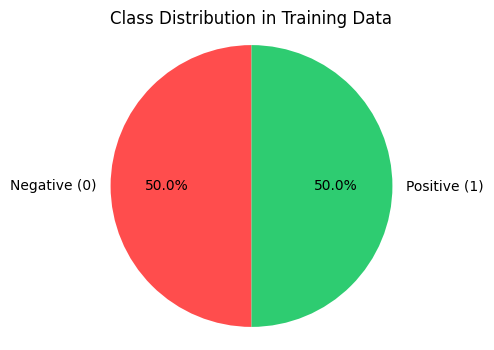

In [58]:
# Class distribution (0s and 1s)
class_counts = train_df['label'].value_counts()

# Create the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=['Negative (0)', 'Positive (1)'], autopct='%1.1f%%', startangle=90, colors=['#ff4d4d','#2ECC71'])
plt.title('Class Distribution in Training Data')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
plt.show()

# Model Train & Evaluation 

In [59]:
import pickle
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


In [60]:
# Define scoring functions
def training_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Training Scores: \n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

def validation_scores(y_act, y_pred):
    acc = round(accuracy_score(y_act, y_pred), 3)
    pr = round(precision_score(y_act, y_pred), 3)
    rec = round(recall_score(y_act, y_pred), 3)
    f1 = round(f1_score(y_act, y_pred), 3)
    print(f'Testing Scores: \n\tAccuracy = {acc}\n\tPrecision = {pr}\n\tRecall = {rec}\n\tF1-Score = {f1}')

# Test Logistic Regression

In [61]:

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

print("\n=== Training Set ===")
training_scores(y_train, y_train_pred_lr)

print("\n=== Test Set ===")
validation_scores(y_test, y_test_pred_lr)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_lr, digits=3))


=== Training Set ===
Training Scores: 
	Accuracy = 0.83
	Precision = 0.844
	Recall = 0.809
	F1-Score = 0.826

=== Test Set ===
Testing Scores: 
	Accuracy = 0.768
	Precision = 0.785
	Recall = 0.74
	F1-Score = 0.762

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.752     0.795     0.773      4972
           1      0.785     0.740     0.762      5028

    accuracy                          0.768     10000
   macro avg      0.768     0.768     0.767     10000
weighted avg      0.769     0.768     0.767     10000



# Test Naive Bayes (MultinomialNB)

In [29]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

y_train_pred_mnb = mnb.predict(X_train)
y_test_pred_mnb = mnb.predict(X_test)

print("\n=== Training Set ===")
training_scores(y_train, y_train_pred_mnb)

print("\n=== Test Set ===")
validation_scores(y_test, y_test_pred_mnb)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_mnb, digits=3))


=== Training Set ===
Training Scores: 
	Accuracy = 0.807
	Precision = 0.825
	Recall = 0.779
	F1-Score = 0.802

=== Test Set ===
Testing Scores: 
	Accuracy = 0.765
	Precision = 0.784
	Recall = 0.735
	F1-Score = 0.758

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.748     0.795     0.770      4972
           1      0.784     0.735     0.758      5028

    accuracy                          0.765     10000
   macro avg      0.766     0.765     0.764     10000
weighted avg      0.766     0.765     0.764     10000



# Test Random Forest

In [30]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

print("\n=== Training Set ===")
training_scores(y_train, y_train_pred_rf)

print("\n=== Test Set ===")
validation_scores(y_test, y_test_pred_rf)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_rf, digits=3))


=== Training Set ===
Training Scores: 
	Accuracy = 0.984
	Precision = 0.98
	Recall = 0.988
	F1-Score = 0.984

=== Test Set ===
Testing Scores: 
	Accuracy = 0.75
	Precision = 0.774
	Recall = 0.709
	F1-Score = 0.74

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.729     0.790     0.758      4972
           1      0.774     0.709     0.740      5028

    accuracy                          0.750     10000
   macro avg      0.751     0.750     0.749     10000
weighted avg      0.751     0.750     0.749     10000



# Test DecisionTree

In [31]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

y_train_pred_dt = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

print("=== Training Set ===")
training_scores(y_train, y_train_pred_dt)

print("\n=== Test Set ===")
validation_scores(y_test, y_test_pred_dt)

print("\n=== Classification Report ===")
print(classification_report(y_test, y_test_pred_dt, digits=3))

=== Training Set ===
Training Scores: 
	Accuracy = 0.984
	Precision = 0.983
	Recall = 0.985
	F1-Score = 0.984

=== Test Set ===
Testing Scores: 
	Accuracy = 0.7
	Precision = 0.71
	Recall = 0.679
	F1-Score = 0.695

=== Classification Report ===
              precision    recall  f1-score   support

           0      0.690     0.720     0.704      4972
           1      0.710     0.679     0.695      5028

    accuracy                          0.700     10000
   macro avg      0.700     0.700     0.700     10000
weighted avg      0.700     0.700     0.699     10000



# Save Best Model

In [40]:
# Save Logistic Regression model
save_directory = '../static/model/'
os.makedirs(save_directory, exist_ok=True)
filename_lr = os.path.join(save_directory, 'model.pkl')
with open(filename_lr, 'wb') as file:
    pickle.dump(lr, file)

print(f"Logistic Regression model saved as: {filename_lr}")

Logistic Regression model saved as: logistic_regression_Latest_model_BR3.pkl


# Prepare Keggle Submission File

In [41]:

# 1. Prepare Full Training Data
print("\nPreparing full training data for submission...")
X_full = vectorizer(train_df['processed_text'], tokens)  # Use entire 50k samples
y_full = train_df['label']

# 2. Train Final Logistic Regression Model
print("Training final model on full dataset...")
final_model = LogisticRegression(max_iter=1000)
final_model.fit(X_full, y_full)

# 3. Vectorize Competition Data (Using Same Vocabulary)
X_competition = vectorizer(test_df['processed_text'], tokens)

# 4. Generate Predictions
print("Generating competition predictions...")
competition_preds = final_model.predict(X_competition)

# 5. Create Submission File
submission = pd.DataFrame({
    'id': test_df['id'],
    'sentiment': competition_preds
})

# 6. Save Submission
submission_filename = "TweetSentimentAnalyseSub1.csv"
download_path = os.path.join(r"C:\Users\Ishara Maduranga\Downloads", submission_filename)
submission.to_csv(download_path, index=False)


print(f"""
=== Submission Summary ===
File saved: {submission_file}
Total predictions: {len(submission)}
Class distribution:
{submission['sentiment'].value_counts()}

Sample predictions:
{submission.head(3)}
""")



Preparing full training data for submission...
Training final model on full dataset...
Generating competition predictions...

=== Submission Summary ===
File saved: TweetSentimentAnalyseBR3.csv
Total predictions: 5000
Class distribution:
sentiment
0    2583
1    2417
Name: count, dtype: int64

Sample predictions:
                    id  sentiment
0  1029570266916159488          1
1  1030496040649142272          0
2  1030496928755314688          0



# ===========================================